In [1]:
from scsim import scsim
import scanpy as sc

# Simulate scRNA-Seq data with RNA dropout

In [2]:
# scRNA-seq simulation parameters are taken from https://codeocean.com/capsule/6314882/tree/v1, code/analysis/Part1_Simulations/Step1_Simulate.ipynb 
# a few are changed for demonstration purposes

seed = 2
ngenes = 1000 # 25000
descale = 1.0
ndoublets = 100
K = 6 # 13
nproggenes = int(ngenes * 0.1) # 1000
proggroups = [1,2,3,4]
progcellfrac = .35
ncells = 1500
deprob = .025

libloc = 7.64
libscale = 0.78
mean_rate = 7.68
mean_shape = 0.34
expoutprob = 0.00286
expoutloc = 6.15
expoutscale = 0.49
diffexpdownprob = 0.
bcv_dispersion = 0.448
bcv_dof = 22.087
progdownprob = 0.

minprogusage = .1
maxprogusage = .7

deloc = 5.0 # changed 

In [3]:
# simulating original counts
simulator = scsim(ngenes=ngenes, ncells=ncells, ngroups=K, libloc=libloc, libscale=libscale,
                mean_rate=mean_rate, mean_shape=mean_shape, expoutprob=expoutprob,
                expoutloc=expoutloc, expoutscale=expoutscale,
                diffexpprob=deprob, diffexpdownprob=diffexpdownprob, diffexploc=deloc, diffexpscale=descale,
                bcv_dispersion=bcv_dispersion, bcv_dof=bcv_dof, ndoublets=ndoublets,
                nproggenes=nproggenes, progdownprob=progdownprob, progdeloc=deloc,
                progdescale=descale, progcellfrac=progcellfrac, proggoups=proggroups,
                minprogusage=minprogusage, maxprogusage=maxprogusage, seed=seed)             
simulator.simulate()

adata_org = sc.AnnData(simulator.counts, obs=simulator.cellparams, var=simulator.geneparams)
adata_org.obs['group'] = adata_org.obs['group'].astype('str')
adata_org.obs['desc'] = 'original'

Simulating cells
Simulating gene params
Simulating program
Simulating DE
Simulating cell-gene means
   - Getting mean for activity program carrying cells
   - Getting mean for non activity program carrying cells
   - Normalizing by cell libsize
Simulating doublets
Adjusting means
Simulating counts with scsim


/var/folders/8y/cpqrd46n7ml80f139vjz9l240000gn/T/ipykernel_37154/3637963678.py:12: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_org = sc.AnnData(simulator.counts, obs=simulator.cellparams, var=simulator.geneparams)


/Users/nomo/opt/miniconda3/envs/scsim/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


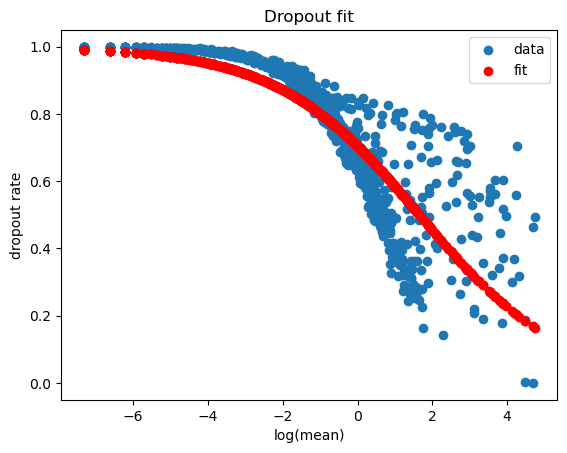

In [4]:
# following Splatter, we fit the number of zeros vs log mean curve in the current data
dropshape, dropmidpoint = simulator.fit_dropout(plot=True)

In [5]:
# to add technical dropout noise, we decrease the sigmoid's dropmidpoint
# note that a dropout effect happens also when keeping dropmidpoint constant because it represents the avg dropout 
# so cell,gene counts with lower dropout values will be subsampled

inc_dropmidpoint = -0.001
simulator.dropshape = dropshape
simulator.dropmidpoint = dropmidpoint + inc_dropmidpoint

simulator.simulate_dropouts() # saves counts with dropout to simulator.countswdrop

adata_drp = sc.AnnData(simulator.countswdrop, obs=simulator.cellparams, var=simulator.geneparams)
adata_drp.obs['group'] = adata_drp.obs['group'].astype('str')
adata_drp.obs['desc'] = 'with dropout'

/Users/nomo/opt/miniconda3/envs/scsim/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/var/folders/8y/cpqrd46n7ml80f139vjz9l240000gn/T/ipykernel_37154/1055519983.py:10: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_drp = sc.AnnData(simulator.countswdrop, obs=simulator.cellparams, var=simulator.geneparams)


/Users/nomo/opt/miniconda3/envs/scsim/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/nomo/opt/miniconda3/envs/scsim/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/nomo/opt/miniconda3/envs/scsim/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


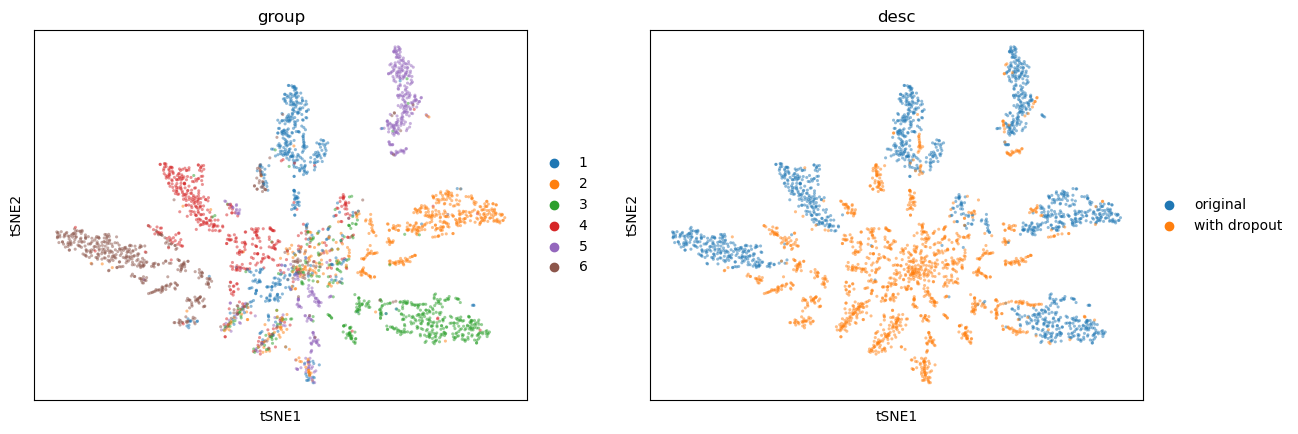

In [6]:
# plot original vs with dropout
adata = sc.concat([adata_org, adata_drp], axis=0)
sc.tl.pca(adata)
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['group', 'desc'], size=20, alpha=0.5)